In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# Merge customer and transaction data
customer_transactions = pd.merge(transactions, customers, on='CustomerID', how='left')
customer_products = pd.merge(customer_transactions, products, on='ProductID', how='left')

In [4]:
# Aggregate transaction data for each customer
# Merge with customer demographic data

customer_aggregation = customer_products.groupby('CustomerID').agg({
    'TotalValue': 'sum',     # Total spending
    'TransactionID': 'count' # Number of transactions
}).rename(columns={'TotalValue': 'TotalSpending', 'TransactionID': 'TransactionCount'}).reset_index()

customer_clustering_data = pd.merge(customers, customer_aggregation, on='CustomerID', how='inner')

In [5]:
# Extract features for clustering (Region encoded as dummy variable, spending, and transactions)
region_dummies = pd.get_dummies(customer_clustering_data['Region'], prefix='Region')
features = pd.concat([region_dummies, customer_clustering_data[['TotalSpending', 'TransactionCount']]], axis=1)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-means clustering (trying k from 2 to 10)
db_scores = []
silhouette_scores = []
k_values = range(2, 11)
cluster_results = {}

In [6]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    silhouette_avg = silhouette_score(scaled_features, labels)
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)
    cluster_results[k] = labels

# Find the optimal number of clusters based on the DB index (lower is better)
optimal_k = k_values[db_scores.index(min(db_scores))]

c:\Users\harsh\anaconda3\envs\py3.9\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\harsh\anaconda3\envs\py3.9\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\harsh\anaconda3\envs\py3.9\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\harsh\anaconda3\envs\py3.9\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMe

In [7]:
# Apply K-means with the optimal number of clusters
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_clustering_data['Cluster'] = final_kmeans.fit_predict(scaled_features)

c:\Users\harsh\anaconda3\envs\py3.9\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


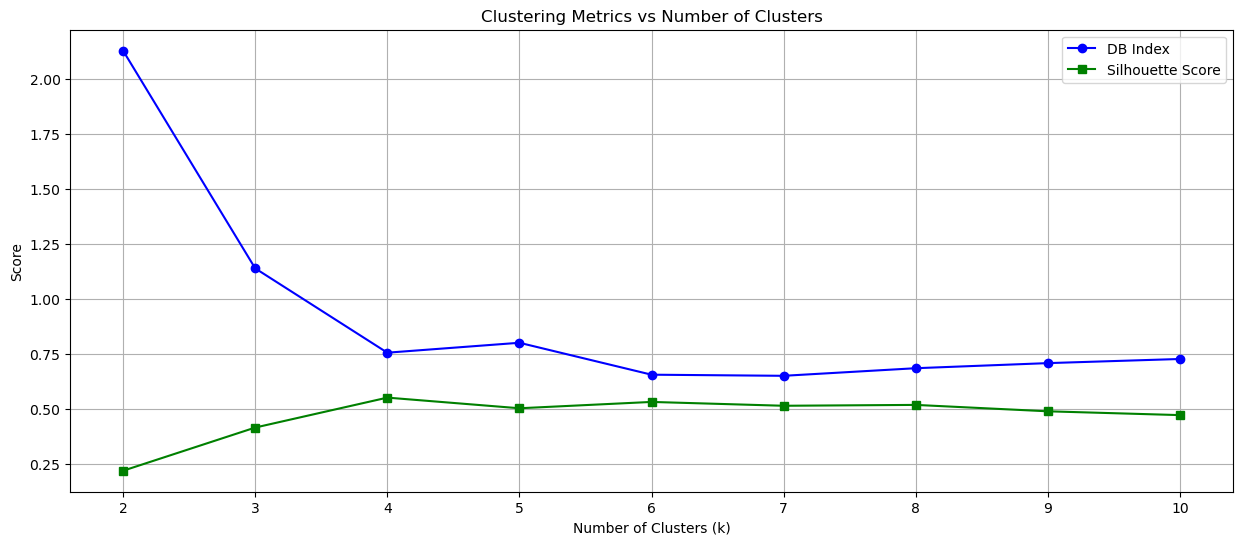

In [8]:
# Visualize DB Index and Silhouette Scores vs Number of Clusters
plt.figure(figsize=(15, 6))
plt.plot(k_values, db_scores, marker='o', label='DB Index', color='blue')
plt.plot(k_values, silhouette_scores, marker='s', label='Silhouette Score', color='green')
plt.title('Clustering Metrics vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

In [9]:
# Cluster Composition Analysis
region_distribution_by_cluster = customer_clustering_data.groupby('Cluster')['Region'].value_counts(normalize=True).unstack().fillna(0)

cluster_summary_detailed = customer_clustering_data.groupby('Cluster').agg({
    'TotalSpending': ['mean', 'median', 'std'],
    'TransactionCount': ['mean', 'median', 'std'],
    'CustomerID': 'count'  # Number of customers in each cluster
}).rename(columns={'CustomerID': 'CustomerCount'}).reset_index()

In [10]:
# Representative customers from each cluster
representative_customers = customer_clustering_data.loc[
    customer_clustering_data.groupby('Cluster')['TotalSpending'].idxmax(),
    ['Cluster', 'CustomerID', 'TotalSpending', 'TransactionCount', 'Region']
]

# Extract cluster centers for insights
cluster_centers = scaler.inverse_transform(final_kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features.columns)

In [11]:
# Dimensionality Reduction for Visualization (PCA)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
customer_clustering_data['PCA1'] = pca_features[:, 0]
customer_clustering_data['PCA2'] = pca_features[:, 1]

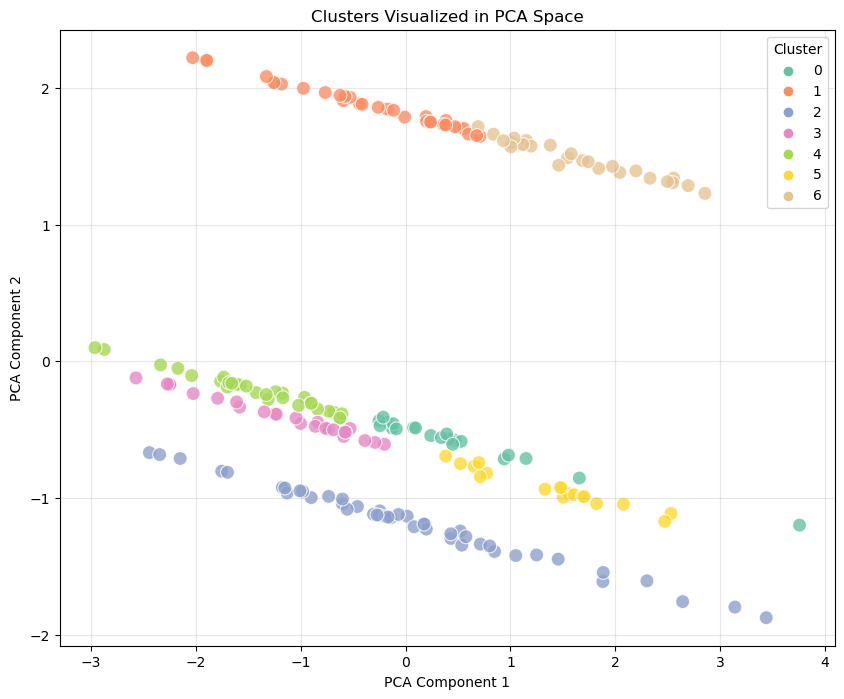

In [12]:
# Scatter plot of clusters in PCA-reduced space
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_clustering_data,
    palette='Set2', s=100, alpha=0.8
)
plt.title('Clusters Visualized in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(alpha=0.3)
plt.show()


In [13]:
# Display cluster analysis results
print("\nCluster Composition by Region:")
print(region_distribution_by_cluster)
print("\nCluster Summary:")
print(cluster_summary_detailed)
print("\nRepresentative Customers:")
print(representative_customers)
print("\nCluster Centers:")
print(cluster_centers_df)



Cluster Composition by Region:
Region   Asia  Europe  North America  South America
Cluster                                            
0         0.0     1.0            0.0            0.0
1         0.0     0.0            0.0            1.0
2         0.0     0.0            1.0            0.0
3         1.0     0.0            0.0            0.0
4         0.0     1.0            0.0            0.0
5         1.0     0.0            0.0            0.0
6         0.0     0.0            0.0            1.0

Cluster Summary:
  Cluster TotalSpending                        TransactionCount         \
                   mean    median          std             mean median   
0       0   5048.289524  4931.740  1502.766396         6.190476    6.0   
1       1   2415.905152  2598.330  1120.724739         3.909091    4.0   
2       2   3311.160870  3034.210  1701.181711         5.304348    5.0   
3       3   2124.869231  2187.210   909.341032         3.192308    3.0   
4       4   2077.260345  2138.260   90